<a href="https://colab.research.google.com/github/Alvorecer721/Applied-Data-Analysis/blob/main/project/exploitation/clustering_city.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/EPFL/Network_ML/Project")  # To import utils

from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle
np.random.seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install grakel einops torch_geometric node2vec

In [ ]:
!pip install bayesian-optimization

In [4]:
%cd /content/drive/MyDrive/EPFL/Network_ML/Project/exploitation

/content/drive/MyDrive/EPFL/Network_ML/Project/exploitation


### Local Setup

In [ ]:
import sys
sys.path.append("../")  # To import utils

from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle
np.random.seed(42)

%load_ext autoreload
%autoreload 2

### Clustering

In [5]:
all_cities = list_cities()

#### Training

In [6]:
from training import *
from prepare_data import load_features
from matplotlib import pyplot as plt

In [7]:
graph_list = [load_graph(city, transport) for city in tqdm(all_cities) for transport in ["combined"]]

100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


In [8]:
K = compute_graph_kernels(graph_list)

100%|██████████| 25/25 [00:00<00:00, 30.99it/s]
/usr/local/lib/python3.10/dist-packages/grakel/graph_kernels.py:495: UserWarning: Kernel List not empty while reaching a base-kernel - the rest kernel names will be ignored
  warnings.warn('Kernel List not empty while reaching a base-kernel - '


In [85]:
def get_neighbouring_cities(target_city, given_cities, K, num_neighbour=5):
    """
    Returns the neighbouring cities based on the similarity matrix.

    Args:
        city (str): The name of the city.
        all_cities (list): List of all cities.
        K (np.ndarray): The similarity matrix.
        num_neighbour (int): The number of neighbouring cities to return. Default is 7.

    Returns:
        neighbouring_cities (list): List of neighbouring cities.
    """

    if target_city in given_cities:
        city_idx = given_cities.index(city)

        sorted_indices = np.argsort(K[city_idx])

        assert city == given_cities[sorted_indices[-1]], "the most similar city must be the city itself"

        highest_value_indices = sorted_indices[::-1][:1+num_neighbour]
        neighbouring_cities = [given_cities[idx] for idx in highest_value_indices]

        return neighbouring_cities
    else:
        raise ValueError("City not found in list of all cities")


In [149]:
target_city = 'berlin'
num_neighbour = 5
neighbouring_cities = get_neighbouring_cities(target_city, all_cities, K, num_neighbour)
print(neighbouring_cities)

['berlin', 'turku', 'sydney', 'toulouse', 'kuopio', 'helsinki']


In [143]:
data = [load_features(city, task="duration_regr") for city in neighbouring_cities]

In [144]:
train_split = data[2:] # Bottom k-1 for training
valid_split = data[1:2] # Top 1 for validating
test_split  = data[:1]

In [132]:
import torch_geometric.nn as graphnn
import torch.nn as nn
import torch
from einops import rearrange
import torch.nn.functional as F

class SimpleGCN(nn.Module):

    def __init__(self, num_features, num_classes, hidden_dim=4, seed=0):
        super().__init__()
        torch.manual_seed(0)
        self.graphconv1 = graphnn.GCNConv(num_features, hidden_dim)
        self.graphconv2 = graphnn.GCNConv(hidden_dim, 2 * hidden_dim)
        self.graphconv3 = graphnn.GCNConv(2 * hidden_dim, hidden_dim)

        self.classifier = nn.Linear(2 * hidden_dim, num_classes)
        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)
        x = self.elu(x)

        # Reorder axis and concat node embeddings for each edge
        out = rearrange(x[edge_index], "two bs emb_dim -> bs (two emb_dim)")
        out = self.classifier(out)

        return out
        

class GAT(nn.Module):
  def __init__(
        self, 
        num_features, 
        num_classes,
        hidden_dim=4, 
        use_skip_connection=True,
        heads=1,
        output_heads=6,
    ):
      super().__init__()
      
      self.gc1 = graphnn.GATConv(num_features, hidden_dim, heads=heads, act=None)
      self.gc2 = graphnn.GATConv(hidden_dim * heads, hidden_dim, heads=heads, act=None)
      self.gc3 = graphnn.GATConv(hidden_dim * heads, hidden_dim, heads=output_heads, act=None, concat=False)   

      if use_skip_connection:
         self.opt_skip = lambda x, edge_index, layer: x + layer(x, edge_index)
      else:
         self.opt_skip = lambda x, edge_index, layer: layer(x, edge_index)

      self.classifier = nn.Linear(2 * hidden_dim, num_classes)
      self.elu = nn.ELU()

      
  def forward(self, x, edge_index):

      x = self.gc1(x, edge_index)
      x = self.elu(x)
      x = self.opt_skip(x, edge_index, self.gc2)
      x = self.elu(x)
      x = self.gc3(x, edge_index)
      x = self.elu(x)

      # Reorder axis and concat node embeddings for each edge
      out = rearrange(x[edge_index], "two bs emb_dim -> bs (two emb_dim)")
      out = self.classifier(out)

      return out

# class SimpleGCN(torch.nn.Module):
#     def __init__(self, num_features, num_classes, hidden_dim=4, seed=0):
#         super().__init__()
#         torch.manual_seed(0)
#         self.conv1 = graphnn.GCNConv(num_features, hidden_dim)
#         self.conv2 = graphnn.GCNConv(hidden_dim, 2 * hidden_dim)
#         self.conv3 = graphnn.GCNConv(2 * hidden_dim, hidden_dim)

#         self.classifier = nn.Linear(2 * hidden_dim, num_classes)

#     def forward(self, x, edge_index):
#         h = self.conv1(x, edge_index)
#         h = h.tanh()
#         h = self.conv2(h, edge_index)
#         h = h.tanh()
#         h = self.conv3(h, edge_index)
#         h = h.tanh()
#         # Reorder axis and concat node embeddings for each edge
#         h_out = rearrange(h[edge_index], "two bs emb_dim -> bs (two emb_dim)")
#         out = self.classifier(h_out)

#         return out

In [133]:
from bayes_opt import BayesianOptimization

# Objective function
def optimize_model(lr: float, weight_decay: float, hidden_dim: int, device: str, train_split, valid_split):
    hidden_dim = int(hidden_dim)  # cast to int because BayesianOptimization explores the space with floats

    # Define model
    # model = SimpleGCN(168, 1, hidden_dim=hidden_dim)
    model = GAT(168, 1, hidden_dim=hidden_dim)
    model = model.to(device)

    # Define optimizer with hyperparameters to optimize
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Define criterion
    criterion = nn.MSELoss()

    # Your training function
    result_dict = pyg_train(
        model=model,
        device=device,
        train_split=train_split,
        valid_split=valid_split,
        optimizer=optimizer,
        criterion=criterion
    )

    # We want to maximize the validation metric (accuracy, F1 score, etc.)
    # But if metric is MSE or MAE, negate the MSE to make lower MSE better
    mse = result_dict["eval_metrics"][-1]['mse'].cpu()
    rmse = torch.sqrt(mse)
    return -rmse

# Bounded region of parameter space
pbounds = {'lr': (1e-5, 1e-3), 'weight_decay': (1e-5, 1e-3), 'hidden_dim': (512, 1028)}


tuner = BayesianOptimization(
    f=lambda lr, weight_decay, hidden_dim: optimize_model(lr, weight_decay, hidden_dim, 
                                                          device='cuda',
                                                          train_split=train_split,
                                                          valid_split=valid_split),
    pbounds=pbounds,
    random_state=1,
)

tuner.maximize(
    init_points=10,
    n_iter=30,
)

print(tuner.max)


|   iter    |  target   | hidden... |    lr     | weight... |
-------------------------------------------------------------



Regression train...: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


| 1         | -2.384    | 727.2     | 0.0007231 | 1.011e-05 |



Regression train...: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


| 2         | -2.417    | 668.0     | 0.0001553 | 0.0001014 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


| 3         | -2.412    | 608.1     | 0.0003521 | 0.0004028 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


| 4         | -2.435    | 790.0     | 0.000425  | 0.0006884 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


| 5         | -2.38     | 617.5     | 0.0008793 | 3.711e-05 |



Regression train...: 100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


| 6         | -2.402    | 858.0     | 0.0004231 | 0.0005631 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


| 7         | -2.397    | 584.4     | 0.0002061 | 0.0008027 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


| 8         | -2.424    | 1.012e+03 | 0.0003203 | 0.0006954 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


| 9         | -2.373    | 964.2     | 0.0008957 | 9.419e-05 |



Regression train...: 100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


| 10        | -2.42     | 532.2     | 0.0001781 | 0.0008794 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


| 11        | -2.408    | 964.4     | 0.0005769 | 0.0009431 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


| 12        | -2.39     | 786.7     | 0.0007895 | 0.0001832 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


| 13        | -2.418    | 819.5     | 0.0002684 | 0.0007493 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


| 14        | -2.436    | 629.4     | 0.000164  | 0.0009478 |



Regression train...: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


| 15        | -2.428    | 886.7     | 0.0007313 | 0.0002027 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


| 16        | -2.523    | 754.6     | 0.0004293 | 0.0004772 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


| 17        | -2.434    | 1.005e+03 | 0.0006674 | 0.000476  |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


| 18        | -2.417    | 764.2     | 0.0008428 | 0.0009793 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


| 19        | -2.418    | 964.1     | 0.0008321 | 0.0003721 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.80it/s]


| 20        | -2.435    | 953.2     | 0.0007222 | 0.0009129 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


| 21        | -2.385    | 861.4     | 0.0005524 | 0.0003894 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 16.15it/s]


| 22        | -2.462    | 584.6     | 0.000148  | 0.0003237 |



Regression train...: 100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


| 23        | -2.486    | 653.4     | 0.0007667 | 7.62e-05  |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.23it/s]


| 24        | -2.413    | 617.6     | 0.0007847 | 0.0003944 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


| 25        | -2.424    | 820.7     | 0.0001216 | 0.0001256 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


| 26        | -2.45     | 828.6     | 0.0005618 | 0.0006571 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s]


| 27        | -2.415    | 727.2     | 0.0004206 | 0.0008978 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


| 28        | -2.394    | 617.5     | 0.0009846 | 0.0005172 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


| 29        | -2.395    | 617.5     | 0.0008631 | 0.0009311 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.52it/s]


| 30        | -2.403    | 617.5     | 0.0008199 | 0.0008171 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.79it/s]


| 31        | -2.399    | 964.3     | 0.0001886 | 0.0002877 |



Regression train...: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


| 32        | -2.427    | 630.7     | 7.414e-05 | 0.0007068 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


| 33        | -2.399    | 786.7     | 0.000431  | 0.0006838 |



Regression train...: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]


| 34        | -2.421    | 727.2     | 0.0007727 | 6.42e-05  |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


| 35        | -2.403    | 945.0     | 0.0004243 | 0.0003031 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


| 36        | -2.433    | 964.2     | 0.0006494 | 7.254e-05 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


| 37        | -2.385    | 861.4     | 0.0007066 | 0.0008046 |



Regression train...: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


| 38        | -2.413    | 786.6     | 0.0006419 | 0.0007163 |



Regression train...: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


| 39        | -2.379    | 964.2     | 0.0004076 | 0.0006946 |



Regression train...: 100%|██████████| 100/100 [00:09<00:00, 10.06it/s]

| 40        | -2.396    | 861.4     | 0.0004747 | 0.0003827 |
{'target': -2.3726842403411865, 'params': {'hidden_dim': 964.2168025847558, 'lr': 0.0008956605968688089, 'weight_decay': 9.419376925608012e-05}}


In [145]:
optimal_params = tuner.max['params']
device = "cuda"
batch_size = 1
num_steps = 1000
eval_every = 20

In [146]:
optimal_hidden_dim = int(optimal_params['hidden_dim'])  # make sure to cast to int because the optimizer works with float
optimal_lr = optimal_params['lr']
optimal_weight_decay = optimal_params['weight_decay']

# Initialize your model with the optimal hidden dimension
# model = SimpleGCN(168, 1, hidden_dim=optimal_hidden_dim)
model = GAT(168, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

# Initialize your optimizer with the optimal learning rate and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion = torch.nn.MSELoss()

# Now you can train your model with the optimal hyperparameters
results = pyg_train(
    model, 
    device, 
    train_split+valid_split, # include the closest neighbour
    test_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
)



Regression train...: 100%|██████████| 1000/1000 [00:51<00:00, 19.38it/s]


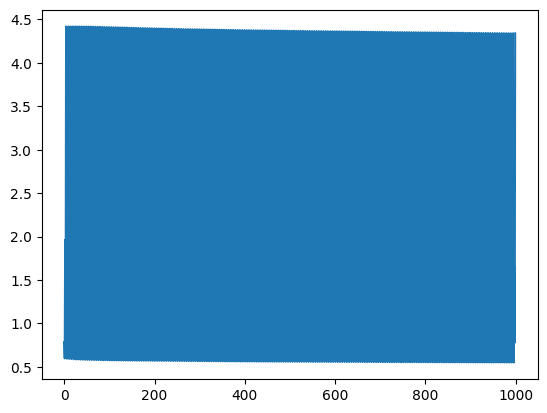

In [147]:
plt.plot(results["loss"])

In [148]:
results["eval_metrics"]

[{'mse': tensor(0.9489, device='cuda:0'),
  'mae': tensor(0.4346, device='cuda:0')},
 {'mse': tensor(0.9260, device='cuda:0'),
  'mae': tensor(0.4366, device='cuda:0')},
 {'mse': tensor(0.9099, device='cuda:0'),
  'mae': tensor(0.4382, device='cuda:0')},
 {'mse': tensor(0.8975, device='cuda:0'),
  'mae': tensor(0.4392, device='cuda:0')},
 {'mse': tensor(0.8875, device='cuda:0'),
  'mae': tensor(0.4400, device='cuda:0')},
 {'mse': tensor(0.8789, device='cuda:0'),
  'mae': tensor(0.4407, device='cuda:0')},
 {'mse': tensor(0.8712, device='cuda:0'),
  'mae': tensor(0.4413, device='cuda:0')},
 {'mse': tensor(0.8642, device='cuda:0'),
  'mae': tensor(0.4419, device='cuda:0')},
 {'mse': tensor(0.8577, device='cuda:0'),
  'mae': tensor(0.4425, device='cuda:0')},
 {'mse': tensor(0.8517, device='cuda:0'),
  'mae': tensor(0.4432, device='cuda:0')},
 {'mse': tensor(0.8460, device='cuda:0'),
  'mae': tensor(0.4439, device='cuda:0')},
 {'mse': tensor(0.8407, device='cuda:0'),
  'mae': tensor(0.4447,

In [150]:
data = [load_features(city, task="duration_regr") for city in all_cities]

In [151]:
city_index = all_cities.index(target_city)
train_split = data[:city_index] + data[city_index+1:]
valid_split = data[city_index:city_index+1]

In [152]:
# Initialize your model with the optimal hidden dimension
# model = SimpleGCN(168, 1, hidden_dim=optimal_hidden_dim)
model = GAT(168, 1, hidden_dim=optimal_hidden_dim)
model = model.to(device)

# Initialize your optimizer with the optimal learning rate and weight decay
optimizer = torch.optim.SGD(model.parameters(), lr=optimal_lr, weight_decay=optimal_weight_decay)
criterion = torch.nn.MSELoss()

# Now you can train your model with the optimal hyperparameters
results = pyg_train(
    model, 
    device, 
    train_split,
    valid_split,
    optimizer, 
    criterion, 
    num_steps=num_steps,
    eval_every=eval_every,
    batch_size=batch_size,
)


Regression train...: 100%|██████████| 1000/1000 [00:41<00:00, 24.02it/s]


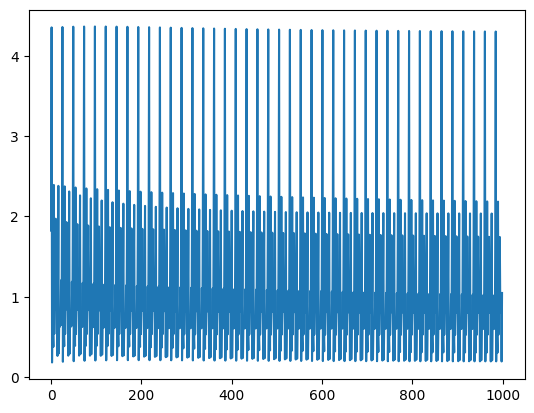

In [153]:
plt.plot(results["loss"])

In [154]:
results["eval_metrics"]

[{'mse': tensor(0.8917, device='cuda:0'),
  'mae': tensor(0.4552, device='cuda:0')},
 {'mse': tensor(0.8801, device='cuda:0'),
  'mae': tensor(0.4569, device='cuda:0')},
 {'mse': tensor(0.8652, device='cuda:0'),
  'mae': tensor(0.4596, device='cuda:0')},
 {'mse': tensor(0.8570, device='cuda:0'),
  'mae': tensor(0.4605, device='cuda:0')},
 {'mse': tensor(0.8473, device='cuda:0'),
  'mae': tensor(0.4627, device='cuda:0')},
 {'mse': tensor(0.8385, device='cuda:0'),
  'mae': tensor(0.4654, device='cuda:0')},
 {'mse': tensor(0.8335, device='cuda:0'),
  'mae': tensor(0.4656, device='cuda:0')},
 {'mse': tensor(0.8299, device='cuda:0'),
  'mae': tensor(0.4660, device='cuda:0')},
 {'mse': tensor(0.8246, device='cuda:0'),
  'mae': tensor(0.4673, device='cuda:0')},
 {'mse': tensor(0.8213, device='cuda:0'),
  'mae': tensor(0.4674, device='cuda:0')},
 {'mse': tensor(0.8171, device='cuda:0'),
  'mae': tensor(0.4690, device='cuda:0')},
 {'mse': tensor(0.8130, device='cuda:0'),
  'mae': tensor(0.4715,

#### Classical ML

In [46]:
import xgboost as xgb

In [44]:
data_cluster_0 = [load_features(city, task="duration_regr", format="numpy") for city in city_clusters[0]]

In [79]:
train_split = data_cluster_0[:-1]
valid_split = data_cluster_0[-1:]

model = xgb.XGBRegressor()

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum"
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [80]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.26725924, 0.9714031)

In [84]:
city_clusters[0][:-2], city_clusters[0][-2:], city_clusters[0][-1:]

(['turku',
  'sydney',
  'toulouse',
  'canberra',
  'brisbane',
  'kuopio',
  'rennes',
  'helsinki'],
 ['berlin', 'grenoble'],
 ['grenoble'])

In [85]:
train_split = data_cluster_0[:2] # compare with result in train.ipynb
valid_split = data_cluster_0[2:5]

model = xgb.XGBRegressor()

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum"
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [86]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.16112868, 1.266837)

In [76]:
city_cluster_1 = [load_features(city, task="duration_regr", format="numpy") for city in city_clusters[1]]
valid_split = city_cluster_1[-2:]

In [77]:
model = xgb.XGBRegressor()

results = sklearn_train(
    model,
    train_split,
    valid_split,
    edge_aggr="sum"
)

Preparing data...
Data prepared
Training model...
Model trained.
Evaluation model...
Model evaluated


In [78]:
results["train_metrics"]["mse"], results["valid_metrics"]["mse"]

(0.25017953, 0.6708018)